<a href="https://colab.research.google.com/github/MadmanMarble/GLAP/blob/main/MidTermProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mid Term Project
##Description of the mid term project: this project implements linear regression from scratch with stochastic gradient descent, without using a library function except of course the necessary functions for array processing and autograd. The given code implements linear regression with the MSE loss function and the assignment is to experiment with other loss functions.
***Notes***: The linear regression code for this notebook is based on ***3.2. Linear Regression Implementation from Scratch*** of the [Dive into Deep Learning Book](https://d2l.ai/index.html)

In [1]:
!pip install -U d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 1.1 MB/s eta 0:00:00
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.7/124.7 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 5.3 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Unin

In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l


In [2]:
# this function generates some values that correspond to a linear function
# this is to use sythetic data to explore linear regression
def synthetic_data(w, b, num_examples):
    """Generate y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape) # generating noise
    return X, y.reshape((-1, 1))

# the weight is chosen as two values. if you change them you will get a different line
# the bias is 4.2
# the
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000) # 1000 is the number of the data points chosen

In [3]:
# this is just an example to show us features at their location and thier values
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([-0.8425,  0.1217]) 
label: tensor([2.0920])


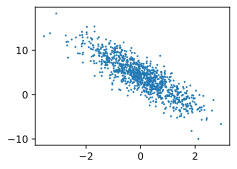

In [4]:
# lets plot the sythetic data that has been generated
d2l.set_figsize()
# The semicolon is for displaying the plot only
d2l.plt.scatter(features[:, 1].detach().numpy(),
                labels.detach().numpy(), 1);

In [5]:
# this is going through different iterations through the data ??
# this is doing the selection
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i +
                                                   batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]


In [6]:
batch_size = 10 # selecting just 10 out of the 1000 that were generated

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 2.0148,  1.8228],
        [ 0.0582, -1.2092],
        [-0.2489, -0.5254],
        [-1.0380, -0.8261],
        [-0.0341, -0.1247],
        [-0.5881,  0.1589],
        [ 1.6011, -0.0717],
        [ 0.6656, -1.3335],
        [-1.3794, -1.0706],
        [ 0.2874, -1.3154]]) 
 tensor([[ 2.0443],
        [ 8.4224],
        [ 5.4782],
        [ 4.9306],
        [ 4.5729],
        [ 2.4850],
        [ 7.6547],
        [10.0701],
        [ 5.0717],
        [ 9.2457]])


In [7]:
# our goal is to find the best values for w and b given the dataset that we have
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [8]:
def linreg(X, w, b):
    """The linear regression model."""
    return torch.matmul(X, w) + b

In [9]:
def squared_loss(y_hat, y):
    """Squared loss."""
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

In [10]:
# stocastic gradient descent
# the initial slope and intersept points could be random
# sgd is trying to get the line closer to the best fit line
# you want to step to the lower loss value
def sgd(params, lr, batch_size):
    """Minibatch stochastic gradient descent."""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()


In [11]:
lr = 0.03 # learning rate. determines the amount of change each time we change the slope and intercept.
# small steps give higher change of not missing the global minimum. bigger steps get you there fast, but you might step over/around it.
num_epochs = 3 # the number of times you iterate. how many times are we stepping the learning rate
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # Minibatch loss in `X` and `y`
        # Compute gradient on `l` with respect to [`w`, `b`]
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # Update parameters using their gradient
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.039421
epoch 2, loss 0.000149
epoch 3, loss 0.000052


In [12]:
print(f'error in estimating w: {true_w - w.reshape(true_w.shape)}')
print(f'error in estimating b: {true_b - b}')

error in estimating w: tensor([-0.0006, -0.0016], grad_fn=<SubBackward0>)
error in estimating b: tensor([0.0012], grad_fn=<RsubBackward1>)


#Assigned tasks:
##The MSE loss function is not the only loss function for linear regression. To be robust to outliers in the training data, the Huber loss and the Log-Cosh are used. Your task is to implement both loss functions in addition to the given MSE loss function (named squared_loss) of this notebook, and to compare their performance on data with outliers. The specific tasks are as follows -
1.   Add two more code cells - one that defines the Huber loss function, and another with defines the Log-Cosh. This [blog post](https://heartbeat.fritz.ai/5-regression-loss-functions-all-machine-learners-should-know-4fb140e9d4b0) describes these loss functions and provides code which is written in numpy so it will need to changed to compatible with PyTorch.
2.   Inject outliers in the data generated by the synthetic data generator of this notebook. You could add random noise to the existing data objects, i.e. changing a given percentage of the data entries to random values within the data range. Inclusion of these outliers will let you compare the benefits of these two loss functions against the MSE.
3.   Create a text cell to summarize your experimental observations as follows: (1) note how many outliers you added (2) compare the error in estimating w and b between MSE, Huber loss, and Log-Cosh loss.







In [ ]:
# Email from professor

# In the mid term project a common question has been: how to create outliers in the synthetic data?
# One way to do that is to generate random numbers from torch.normal (which is used in the
# code for the main distribution) using a large standard deviation (e.g. 5) and add that to
# a subset (e.g. 100 out of 1000) of the y-values that are generated from the main normal distribution


# in class notes from monday 9/16
# this does not effect the assignemnt (just to write about it)

# for jakevdp notebook, there's an error in def hours_of_daylight


# the correct line should be
# days = (date - pd.Timestamp(2000, 12, 21)).days

# it was originally pd.datetime or something similar


In [ ]:
# 1 hr 40 min for log cosh info

In [ ]:
# Task 1: Implement Huber Loss and Log-Cosh Loss Functions
# Create a new code cell to define the Huber loss function.
# Use the Huber loss equation, which changes from quadratic to linear beyond a certain threshold.
# The function should use PyTorch’s tensor operations for compatibility with the rest of the code.
# Create another code cell to define the Log-Cosh loss function.
# This loss function should also be implemented using PyTorch operations, and it will involve calculating the
# logarithm of the hyperbolic cosine of the error.

# Task 2: Inject Outliers in the Data
# Modify the synthetic_data function to inject outliers.
# Add random noise to a given percentage of the dataset (for example, 5-10%) by modifying the generated labels.
# The noise can be generated within the existing data range.
# Ensure that the outliers are introduced after the data is initially generated.


# Task 3: Compare the Loss Functions
# Train the model using the MSE loss, Huber loss, and Log-Cosh loss functions separately, keeping the rest of the code
#  (SGD and linear regression) unchanged.
# Log the errors in estimating weights (w) and bias (b) for each of the loss functions. The error can be calculated as
# the difference between the true values (true_w, true_b) and the estimated values (w, b).




In [27]:
# Define the Huber loss function using PyTorch
def huber_loss(y_pred, y_true, delta=1.0):
    # """
    # Calculate the Huber loss between predicted and true values.

    # Parameters:
    # y_pred (torch.Tensor): Predicted values
    # y_true (torch.Tensor): True values
    # delta (float): The threshold at which the loss changes from quadratic to linear

    # Returns:
    # torch.Tensor: The Huber loss
    # """
    error = y_true - y_pred
    abs_error = torch.abs(error)

    is_small_error = abs_error <= delta
    squared_loss = 0.5 * (error ** 2)
    linear_loss = delta * (abs_error - 0.5 * delta)

    return torch.where(is_small_error, squared_loss, linear_loss).mean()


In [28]:
def log_cosh_loss(y_pred, y_true):
    # """
    # Calculate the Log-Cosh loss between predicted and true values.

    # Parameters:
    # y_pred (torch.Tensor): Predicted values
    # y_true (torch.Tensor): True values

    # Returns:
    # torch.Tensor: The Log-Cosh loss
    # """
    error = y_true - y_pred
    return torch.log(torch.cosh(error)).mean()


In [29]:
def inject_outliers(features, labels, percentage=0.05):
    # """
    # Injects outliers by adding random noise to a percentage of the data.

    # Parameters:
    # features (torch.Tensor): Input features
    # labels (torch.Tensor): True labels
    # percentage (float): Percentage of data to modify with outliers

    # Returns:
    # torch.Tensor: Modified labels with outliers
    # """
    num_outliers = int(percentage * len(labels))
    indices = torch.randperm(len(labels))[:num_outliers]

    # Add random noise to the selected indices in the label data
    labels[indices] += torch.normal(0, 10, size=labels[indices].shape)
    return labels

# Inject 5% outliers
labels_with_outliers = inject_outliers(features, labels.clone(), percentage=0.05)


In [35]:
# Train the model with different loss functions
def train_model(loss_fn, num_epochs=3, lr=0.1):
    w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)

    for epoch in range(num_epochs):
        for X, y in data_iter(batch_size, features, labels_with_outliers):
            l = loss_fn(linreg(X, w, b), y)
            l.sum().backward()
            sgd([w, b], lr, batch_size)

        with torch.no_grad():
            train_l = loss_fn(linreg(features, w, b), labels_with_outliers)
            print(f'Epoch {epoch + 1}, Loss: {float(train_l.mean()):f}')

    print(f'Error in estimating w: {true_w - w.reshape(true_w.shape)}')
    print(f'Error in estimating b: {true_b - b}')

# Train and compare models using different loss functions
print("MSE Loss:")
train_model(squared_loss) # provided in notebook

print("\nHuber Loss:")
train_model(huber_loss)

print("\nLog-Cosh Loss:")
train_model(log_cosh_loss)


MSE Loss:
Epoch 1, Loss: 2.220629
Epoch 2, Loss: 2.225912
Epoch 3, Loss: 2.208471
Error in estimating w: tensor([0.1085, 0.1708], grad_fn=<SubBackward0>)
Error in estimating b: tensor([-0.0009], grad_fn=<RsubBackward1>)

Huber Loss:
Epoch 1, Loss: 3.783197
Epoch 2, Loss: 3.153975
Epoch 3, Loss: 2.547298
Error in estimating w: tensor([ 1.2612, -2.1756], grad_fn=<SubBackward0>)
Error in estimating b: tensor([2.3138], grad_fn=<RsubBackward1>)

Log-Cosh Loss:
Epoch 1, Loss: 3.620594
Epoch 2, Loss: 3.005432
Epoch 3, Loss: 2.416253
Error in estimating w: tensor([ 1.2670, -2.1760], grad_fn=<SubBackward0>)
Error in estimating b: tensor([2.3349], grad_fn=<RsubBackward1>)


**Summary**

---
I added 5% outliers into the data by adding random noise. I compared the performance between MSE loss, Huber loss, and Log-Cosh loss. I set the number of epochs to 3 and set the learning rate to 0.1. The MSE loss is the least robut of the three loss functions. Huber loss and Log-Cosh loss are effective at decreasing the loss value but show results of high error in weights and bias estimates. Overall, Huber loss and Log-Cosh loss are more equipt at handeling data with outliers than MSE loss. MSE loss resulted in the lowest eorros for weights and bias estimates.  


In [ ]:
# Summary

# Task 4: Summarize Observations
# Create a text cell summarizing:
# Number of outliers added to the data (expressed as a percentage or a number).
# Comparison of performance between MSE, Huber loss, and Log-Cosh loss.
# Focus on how robust each loss function is in the presence of outliers.
# Mention which loss function resulted in smaller errors for w and b estimates.

#Assigned tasks:
##This is not a coding task. Create a text cell below this cell, go through the Jake VDP linear regression notebook and write in your own words (2 -3 paragraphs):


*   Different regression techniques presented in the notebook.
*   Think of a problem similar to predicting bicycle traffic and describe how you would solve it with regression.









The Jake VDP notebook covered a few regression techniques. First, simple linear regiression, which fits a straight line to the data, is presented. Scikit-Learn's linear regression used to fine the best-fit line for single and multi-dimensional models is discussed. It also covers basis function regression, including polynomial regression. Gaussian basis functions are discussed. Next, the notebook discusses the use of regularization techniques, those being L2 and L1. Ridge regression (L2 regularization) and Lasso regression (L1 regularization) both are used to help prevent overfitting by penalizing hte size of model coefficients.



---

A similar problem to the one presented here about bicycle traffic data could be using linear regression to predict movie box office revenue. This would be a multiple linear regression problem because there are multiple variables that infuence the revenue. To solve this problem I would list the independent variables:
1. Budget - The amount spent to produce the movie. Higher quality production movies could correlate with higher revenue.
2. Release date - Movies release during certian time periods may perform better than other time periods due to more attendance.
3. Popularity: The name recognition of the director, actors, etc. may attact more audience leading to higher revenue.
4. Genre: Different genres perform differently in theaters. Action movies might have higher revenue than horror movies.

The model could be improved by including more features and data sources such as time series data. This could show changes in audiences behavior over time. Changes in preferences could impact movie sales and revenue. Also, marketing's effectiveness to influence audiences to see the movie could provide insights into movie sales and revenue. I would also inclue demographic information about audiences viewership. There's a lot of variables that could be added to this, but starting here would be provide an introductory method of viewing which of these factors influence movie box office revenues.

In [ ]:
'''

Introduce a practical problem where linear regression can be applied, such as predicting household energy consumption.
Identify potential independent variables: temperature, day of the week, time of day, and whether it is a weekday or weekend.
Explain how regression could help estimate energy use based on these factors, similar to how weather and time predict bicycle traffic.
Discuss briefly how the model could be improved by including additional variables like humidity or special events.
This outline ensures you cover the key elements of regression techniques and a practical example, just as the assignment requires.
Let me know if you'd like to refine any part!

'''